# House pricing model (Rough work)
#### Cleaning, updating and tuning model.


## 🧑🏾‍💻Libraries Imports

In [1]:
import matplotlib.pyplot as  plt
import numpy as np
import re
import time
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


## 🏠 DATA

In [2]:
import pandas as pd
df = pd.read_csv('../Data/cleaned_house_data.csv')
df = df.drop("Unnamed: 0", axis=1)
df

,bedroom,parking_lot,bathroom,toilets,town,state,serviced,extras,Stable Electricity,title,price
0,6.0,0,6.0,7,Ikoyi,Lagos,0,0.0,0,detached duplex,250000000.0
1,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,flat apartment,40000000.0
2,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,flat apartment,20000000.0
3,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,flat apartment,20000000.0
4,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,flat apartment,20000000.0
...,...,...,...,...,...,...,...,...,...,...,...
7263,1.0,1,1.0,1,Oshodi,Lagos,0,8.0,0,mini flat apartment,800000.0
7264,5.0,0,6.0,6,Ikoyi,Lagos,1,0.0,0,terraced duplex,20000000.0
7265,4.0,0,5.0,5,Ikoyi,Lagos,0,0.0,0,terraced duplex,40000000.0
7266,2.0,0,2.0,3,Lekki,Lagos,0,0.0,0,blocks of flats,8500000.0


## 💁🏾‍♂️ Columns details
1. `bedroom` (int) : Number of bedrooms. if bedroom is 1, then it is most likely a self contain. kitchen and living room are standard.<br><br>
2. `parking_lot` (bool) : If a house has a parking lot. <br><br>
3. `bathrooms` (int) : Number of bathrooms. Number will always be <= toilets.<br><br>
4. `toilets` (int) : Number of toilets in the house. Number may be greater than bathrooms if there are singular toilets. e.g guest toilet.<br><br>
5. `town` (str) : Town where house is located.<br><br>
6. `state` (str) : State where house is located.<br><br>
7. `serviced` (bool) : If a house has been serviced or not. Servied houses are residential unit that provides hotel-like amenities and services, such as housekeeping, maintenance, and sometimes even concierge or other optional services. Houses can be rented per day or annually. Dataset focuses on annual prices. Serviced houses may be fully furnished with furniture, lights, Tv's e.t.c. Non serviced properties are residential units that operate indeopendelty and take charge of their living space. <br><br>
8. `extras` (int) : Number of extra features such as, Swimming pool, Free wifi, elevator, Bar space. e.t.c.  <strong>Note: Although the number of extras generally affects, it is not always the case as these features do not all carry the same weight in price.</strong><br><br>.
9. `Stable Electricity` (bool) : If a house has 24 hr Electricity.<br><br>
10. `title` (str) : Type of house.<br><br>
11. `Price` (int) : Annual price of house in Naira.<br><br>

## Data Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7268 entries, 0 to 7267
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedroom             7268 non-null   float64
 1   parking_lot         7268 non-null   int64  
 2   bathroom            7268 non-null   float64
 3   toilets             7268 non-null   int64  
 4   town                7268 non-null   object 
 5   state               7268 non-null   object 
 6   serviced            7268 non-null   int64  
 7   extras              7268 non-null   float64
 8   Stable Electricity  7268 non-null   int64  
 9   title               7268 non-null   object 
 10  price               7268 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 624.7+ KB


In [6]:
# To determine the preprocessors to be used
for label, content in df.items():
    print(f"{label} : {len(df[label].unique())}")

bedroom : 9
parking_lot : 2
bathroom : 10
toilets : 10
town : 83
state : 8
serviced : 2
extras : 12
Stable Electricity : 2
title : 33
price : 139


In [ ]:
# Value count of all columns
for label, content in df.items():
    print(f"{content.value_counts()}")

bedroom
2.0     2028
4.0     1859
3.0     1521
1.0     1150
5.0      611
6.0       61
10.0      25
7.0        9
8.0        4
Name: count, dtype: int64
parking_lot
0    5499
1    1769
Name: count, dtype: int64
bathroom
4.0     1769
3.0     1564
1.0     1411
2.0     1407
5.0      867
6.0      204
10.0      22
7.0       17
8.0        5
9.0        2
Name: count, dtype: int64
toilets
5     1745
3     1648
4     1485
2     1013
1      713
6      570
7       60
10      23
8        6
9        5
Name: count, dtype: int64
town
Lekki              2883
Ajah                735
Ikoyi               599
Victoria Island     314
Ibadan              253
                   ... 
Ojota                 1
Oluyole               1
Akinyele              1
Oshimili              1
Ibadan North          1
Name: count, Length: 83, dtype: int64
state
Lagos     6333
Abuja      639
Oyo        256
Ogun        17
Delta       10
Enugu        7
Kaduna       5
Rivers       1
Name: count, dtype: int64
serviced
0    6841
1   

In [39]:
df["town"].value_counts()[:20]

town
Lekki              2883
Ajah                735
Ikoyi               599
Victoria Island     314
Ibadan              253
Ojodu               213
Yaba                208
Shomolu             141
Surulere            134
Ikeja               132
Gbagada             111
Okota               108
Ogba                100
Maitama              79
Jahi                 78
Kosofe/Ikosi         76
Lugbe                65
Maryland             59
Ikorodu              58
Alimosho             53
Name: count, dtype: int64

## 📊 Data Visualisation

In [4]:
# Finding Correlation between numerical Variables
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

corr_df = pd.DataFrame(corr_matrix)
corr_df

,bedroom,parking_lot,bathroom,toilets,serviced,extras,Stable Electricity,price
bedroom,1.000000,0.056115,0.934918,0.948469,-0.005746,0.062176,0.048681,0.414231
parking_lot,0.056115,1.000000,0.057804,0.067286,0.030091,0.601420,0.516738,0.054325
bathroom,0.934918,0.057804,1.000000,0.945259,-0.012162,0.059771,0.048984,0.377886
toilets,0.948469,0.067286,0.945259,1.000000,0.011712,0.067374,0.049308,0.405949
serviced,-0.005746,0.030091,-0.012162,0.011712,1.000000,0.000758,0.018892,0.027544
extras,0.062176,0.601420,0.059771,0.067374,0.000758,1.000000,0.559594,0.023493
Stable Electricity,0.048681,0.516738,0.048984,0.049308,0.018892,0.559594,1.000000,0.067866
price,0.414231,0.054325,0.377886,0.405949,0.027544,0.023493,0.067866,1.000000


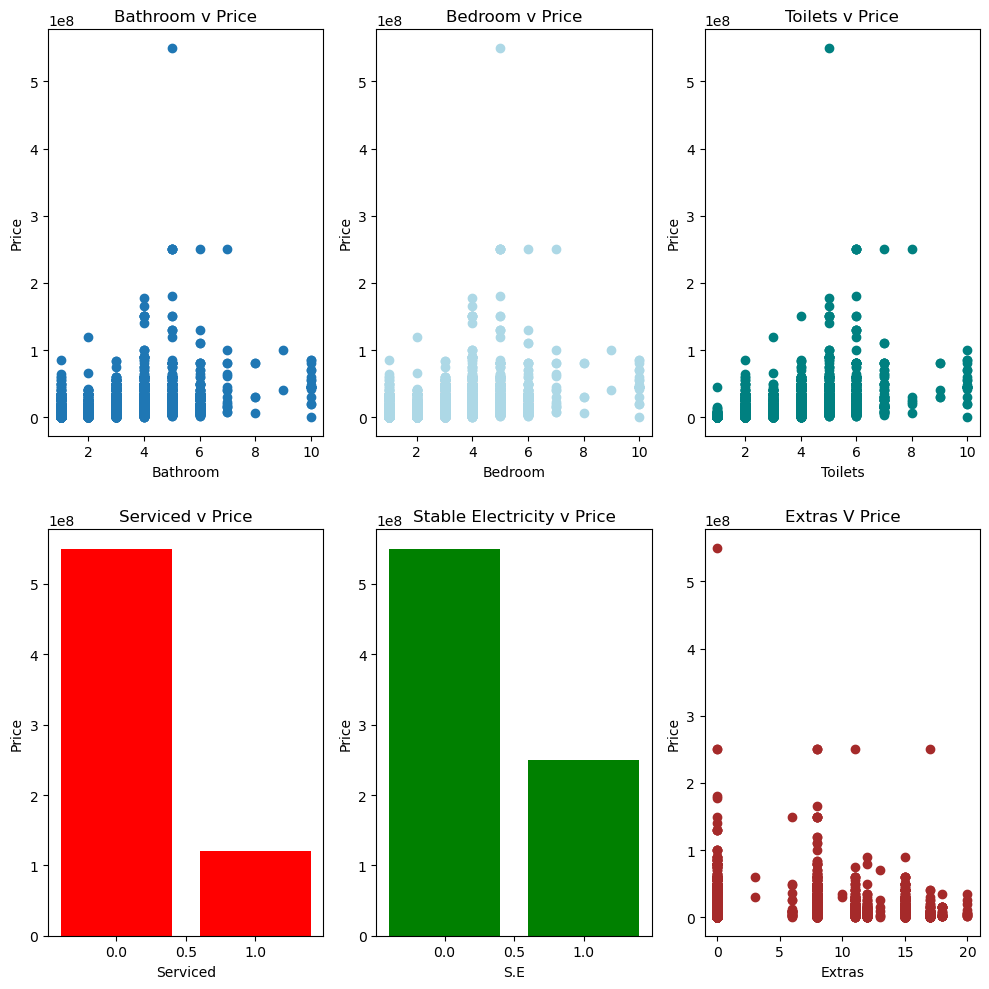

In [5]:
fig, ((ax1,ax2, ax3), (ax4,ax5,ax6), ) = plt.subplots(figsize=(10,10), nrows=2, ncols=3)
ax1.scatter(df.bathroom,df.price)
ax1.set(title="Bathroom v Price", xlabel="Bathroom", ylabel="Price")

ax2.scatter(df.bathroom,df.price, c="lightblue")
ax2.set(title="Bedroom v Price", xlabel="Bedroom", ylabel="Price")

ax3.scatter(df.toilets, df.price, c="teal")
ax3.set(title="Toilets v Price", xlabel="Toilets", ylabel="Price")

ax4.bar(df.serviced, df.price,color="r")
ax4.set(title="Serviced v Price", xlabel="Serviced", ylabel="Price")

ax5.bar(df["Stable Electricity"], df.price,color="g")
ax5.set(title="Stable Electricity v Price", xlabel="S.E", ylabel="Price")

ax6.scatter(df.extras, df.price,color="brown")
ax6.set(title="Extras V Price", xlabel="Extras", ylabel="Price")
plt.tight_layout()


In [6]:
df[["bedroom", "bathroom", "toilets"]].corr()

,bedroom,bathroom,toilets
bedroom,1.000000,0.934918,0.948469
bathroom,0.934918,1.000000,0.945259
toilets,0.948469,0.945259,1.000000


In [7]:
df[["parking_lot", "extras", "serviced", "Stable Electricity"]].corr()

,parking_lot,extras,serviced,Stable Electricity
parking_lot,1.000000,0.601420,0.030091,0.516738
extras,0.601420,1.000000,0.000758,0.559594
serviced,0.030091,0.000758,1.000000,0.018892
Stable Electricity,0.516738,0.559594,0.018892,1.000000


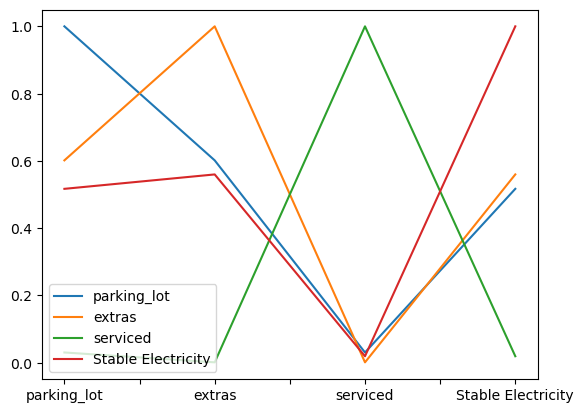

In [8]:
df[["parking_lot", "extras", "serviced", "Stable Electricity"]].corr().plot();

#### 2. Check all features correlation and see how they correlate with each other

In [9]:
df[["parking_lot", "bedroom","Stable Electricity"]].corr()

,parking_lot,bedroom,Stable Electricity
parking_lot,1.000000,0.056115,0.516738
bedroom,0.056115,1.000000,0.048681
Stable Electricity,0.516738,0.048681,1.000000


Conclusion : 
* Bedroom, Bathroom and Toilet have very good correlation with each other (as it should)
* Serviced has the worst correlation with all of them. is it important then?...
  

## 💡 Splitting data and Preprocessing

In [10]:
x = df.drop("price", axis=1) # Feature labels
y = df.price # Target label

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=42)

In [12]:
# logging price to reduce skewness.
y_train, y_test = np.log1p(y_train), np.log1p(y_test)

#### Choosing the right preprocessor
Now before trying to turn non-numerical data, we should note the preprocessors to us. After deliberating, this 3 would be used
1. OneHotEncoder for states (8 unique values) and towns (83 unique values)
2. Target encoding for title (34 unique values)

In [13]:
# features that need to be transformed
state_and_town_feat = ["state", "town"]
title_feat = ["title"]

# Defining Preprocessors
one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')
t_encoder = TargetEncoder(target_type='continuous', cv=5)


transformer = ColumnTransformer(
    [("One_hot",one_hot , state_and_town_feat),
    ("T_Encoder",t_encoder, title_feat)]
   ,remainder="passthrough"
)

# Fit and transform
x_train_encoded = transformer.fit_transform(x_train, np.expm1(y_train))
x_test_encoded = transformer.transform(x_test)

# Get the original columns used
all_input_columns = transformer.feature_names_in_

# Get passthrough columns
explicitly_transformed_cols = state_and_town_feat + title_feat
passthrough_columns = [col for col in all_input_columns if col not in explicitly_transformed_cols]

# Get output feature names from transformers
ohe_feature_names = transformer.named_transformers_["One_hot"].get_feature_names_out(state_and_town_feat).tolist()
target_encoded_names = title_feat  # TargetEncoder keeps column name

# Combine all into final list
final_columns = ohe_feature_names + target_encoded_names + passthrough_columns


/Users/mac/Desktop/ml-course/bulldozer_prediction_project/env/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [14]:
x_train_df = pd.DataFrame(x_train_encoded, columns=final_columns).astype(int)
x_test_df = pd.DataFrame(x_test_encoded, columns=final_columns).astype(int)

In [15]:
x_train_df

,state_Delta,state_Enugu,state_Kaduna,state_Lagos,state_Ogun,state_Oyo,state_Rivers,town_Ado Odo/Ota,town_Agege,town_Ajah,...,town_Wuye,town_Yaba,title,bedroom,parking_lot,bathroom,toilets,serviced,extras,Stable Electricity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,9078362,2,0,2,3,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,22800107,4,0,4,5,0,11,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1051601,1,0,1,1,0,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,14993217,5,0,5,5,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,13653372,4,1,4,5,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,0,0,0,0,0,0,0,0,0,0,...,0,0,13851804,4,0,4,5,0,0,0
6537,0,0,0,1,0,0,0,0,0,0,...,0,0,9320672,3,0,3,4,1,0,0
6538,0,0,0,1,0,0,0,0,0,0,...,0,1,8971169,3,0,3,4,0,0,0
6539,0,0,0,1,0,0,0,0,0,0,...,0,0,23301753,4,1,5,5,0,8,0


## 🧪Model Creation, Fitting and scoring

In [16]:
class HouseEval:
    def __init__(self, x_train, y_train, x_test, y_test, model):
        '''
        Initialises features and target variables
        It takes training and testing data
        '''
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = model
        self.model.fit(self.x_train, self.y_train)
        self.feature_importances_ = model.feature_importances_
        self.feature_names_in_ = model.feature_names_in_

        self.feature_importance_dict = dict(zip(self.feature_names_in_, self.feature_importances_))
        
    def score_model(self):
         np.random.seed(42)
        # Returns the score in R^2 log-space
         return self.model.score(self.x_test, self.y_test)
        
    def metrics(self):
        np.random.seed(42)

        y_preds_log = self.model.predict(self.x_test)
        
        # Convert back to actual price scale
        y_preds = np.expm1(y_preds_log)
        y_true = np.expm1(self.y_test)
        
        # scoring methods
        metrics = {
            "mse": mean_squared_error(y_true, y_preds),
            "mae": mean_absolute_error(y_true, y_preds),
            "mape": mean_absolute_percentage_error(y_true, y_preds),
            "r2": r2_score(y_true, y_preds)
        }

        df_compare = pd.DataFrame({
            "y_true" : y_true,
            "y_preds" : y_preds
        })
        return metrics, df_compare
    def tune(self,n_estimators=[100], max_depth=[100], min_samples_split=[2], min_samples_leaf=[2], max_leaf_nodes=[None],n_jobs=[None], cv=None, verbose=2):
        '''
        This uses GridSearchCV to tune hyperparamters.
        it takes a list of paramter value of each paramter in the model used (in this case RandomForestRegressor)

        n_estimator : Number of trees in the forest. More trees means more decison, slower performance though.
        too much treees can cause overfitting.

        max_depth : Max depth of a tree. Limits how deep trees can go in the decision tree; shallower trees help avoid overfitting.
        Default is none.

        min_samples_split : This sets the minimum number of samples required to split an internal node.
        If min_samples_split=4, a node must have at least 4 rows to try splitting into two child nodes.
        Analogy: You don’t want to make a decision based on just 2 customers. Use more data to decide.

        min_samples_leaf: Minimum number of samples allowed in a leaf node (the last split before prediction).
        E.g., If only one sample of a $500K house exists, 
        we don’t want the model to create a rule only for that — set min_samples_leaf=2 to generalize better.

        max_features: Number (or fraction) of features to consider when looking for the best split.
        
        max_leaf_nodes: Limits the maximum number of leaf nodes in a tree.
        It’s like saying: “Don’t learn more than 10 different price rules.” 

        min_impurity_decrease :A split will only be made if the reduction in impurity (error) is greater than this threshold.
        If splitting based on garage only improves prediction by 0.0001, it won’t split unless min_impurity_decrease < 0.0001

        n_jobs: Number of CPU cores to use (-1 = all)

        cv: cross validation for grid search
        '''
   
        grid = {
            "n_estimators" : n_estimators,
            "max_depth" : max_depth,
            "min_samples_split" : min_samples_split,
            "min_samples_leaf" : min_samples_leaf,
            "max_leaf_nodes" : max_leaf_nodes,
            "n_jobs" : n_jobs
        }
        RsCv = RandomizedSearchCV(self.model, grid, n_iter=40, cv=cv, verbose=verbose, random_state=42)
        RsCv.fit(self.x_train, self.y_train)
        self.model = RsCv
        return RsCv.best_params_, RsCv.score(self.x_test, self.y_test)
        
        
        
        

## FEATURE ENGINEERING

<strong> 1. Training with all features<strong>

In [17]:
model_3 = HouseEval(x_train_df, y_train, x_test_df,y_test, RandomForestRegressor())

In [18]:
model_3.score_model()

0.8315142736116333

In [19]:
model_3.metrics()

({'mse': 67777589493183.13,
  'mae': 3831944.8353952817,
  'mape': 0.37147415661354555,
  'r2': 0.6768788948952617},
           y_true       y_preds
 1414   2500000.0  2.330243e+06
 6901  15000000.0  2.948238e+07
 2862   8000000.0  8.959293e+06
 7175  35000000.0  1.402177e+07
 7083   7000000.0  8.971901e+06
 ...          ...           ...
 4552   6000000.0  6.986201e+06
 4205   1700000.0  2.001337e+06
 1042   3000000.0  6.119385e+06
 447    5000000.0  6.565638e+06
 3649   9000000.0  7.109491e+06
 
 [727 rows x 2 columns])

I have tried and the model is still not up to par. I have looked at the dataset again and came with this conclusion


1. A serviced house (1) doesnt increase price drastically, but it definitelty ups the price, but very very small. because of the prescence of bathroom, toilets, bedroom, location and extras, serviced power is limited. the issue is, adding it to another column might not show how important it is,  but multipltying will lead to the question of, what happens to a house not serviced (0).
2. Stable electricity also has a small correelation to price. Although, that should not be the case considering this is Nigeria. adding it with another column might be the best bet. but how and with which?
3. Extras is supposed to have a good correlation with price, but when using the corr function, i get a very bad score (-0.006). extras refers to the extra things the house comes with like jacuzzi, cinema rooms. granted the extras are not very specific for instance, a house with 5 extras like garden, small hut, study room, security, and street light should not be worth more than a house with 3 extras of cinema room, elevator, and a gym. i hope you get the concept. what should be done with this? removed? I hope not. Worked on again? almost impossible. Added to another column to give it strength? i hope so
4. Parking lot also does have a bad correlation with price, i feel it is not strong on its own.


My solution: Creating more columns for the model to learn more patterns.
1. house_lux_combo = `bedroom + bathroom + toilets * serviced * (stable electricity * 2)`
2. extras_buckets = Creating a bin top store ranges of these values.
3. parking_ratio = `df["parking_lot"] / (df["bedroom"] + 1)`
4. Visitors toilets = `Toilets - bathrooms`
5. is_self_contain = `bedroom == 1`
6. Luxury score = `extras + serviced + stable electrcity + parking_lot`
7.  is_lagos = `state == Lagos`
8.  Extras == 1 if parking_lot || serviced is 1

In [20]:
x_train_edit_df = x_train_df.copy()

In [21]:
# 1. For Serviced and Stable electricity im going to create a house_lux_combo which will be bedroom + bathroom + toilets * serviced * (stable electricity * 2)
x_train_edit_df["house_lux_combo"] = (x_train_df.bedroom + x_train_df.bathroom + x_train_df.toilets) * (1 + x_train_df["Stable Electricity"] * 2)

# 2. extras bucket creation 
x_train_edit_df["extras_bucket"] = pd.cut(x_train_edit_df["extras"], bins=[-1, 2, 4, 6, 16], labels=["low", "medium", "high", "very_high"])
x_train_edit_df = pd.get_dummies(x_train_edit_df, columns=["extras_bucket"], dtype=int)

# 3. df["parking_ratio"] = df["parking_lot"] / (df["bedroom"] + 1) 
x_train_edit_df["parking_ratio"] =  x_train_edit_df["parking_lot"] / (x_train_edit_df["bedroom"] + 1)

# 4. Visitors toilets = Toilets - bathrooms (houses with visitor's toilets may be more expensive
x_train_edit_df["Visitors toilet"] = x_train_edit_df["toilets"] - x_train_edit_df["bathroom"]

# 5. is_self_contain = bedroom == 1
x_train_edit_df["is_self_contain"]= (x_train_edit_df["bedroom"] == 1).astype(int)

# 6. Luxury score = extras + serviced + stable electrcity + parking_lot
x_train_edit_df["luxury_scores"] = x_train_edit_df["extras"] + x_train_edit_df["serviced"] + x_train_edit_df["Stable Electricity"] + x_train_edit_df["parking_lot"]

# 7. Houses in Lagos tend to be more expensive
x_train_edit_df["is_lagos"] = (x_train_edit_df["state_Lagos"] == 1).astype(int)


# 8. Extras == 1 if parking_lot || serviced is 1
x_train_edit_df.loc[
    (x_train_edit_df["parking_lot"] == 1) | (x_train_edit_df["serviced"] == 1),
    "extras"
] = x_train_edit_df["extras"].clip(lower=1)

# 9. Differeentiate Top tier houses
x_train_edit_df["top_tier_houses"] = (
    ((x_train_edit_df["bedroom"] > 4) | (x_train_edit_df["bathroom"] > 4)) &
    (x_train_edit_df["extras"] > 5) &
    (x_train_edit_df["house_lux_combo"] > 10) &
    ((x_train_edit_df["is_lagos"] == 1) |  (x_train_edit_df["town_Ikoyi"] == 1))
).astype(int)


In [22]:
x_test_edit_df = x_test_df.copy()

In [23]:
# 1. For Serviced and Stable electricity im going to create a house_lux_combo which will be bedroom + bathroom + toilets * serviced * (stable electricity * 2)
x_test_edit_df["house_lux_combo"] = (x_test_df.bedroom + x_test_df.bathroom + x_test_df.toilets) * (1 + x_test_df["Stable Electricity"] * 2)

# 2. For extras, i'lll create the extras bucket and add the column 
x_test_edit_df["extras_bucket"] = pd.cut(x_test_edit_df["extras"], bins=[-1, 2, 4, 6, 16], labels=["low", "medium", "high", "very_high"])
x_test_edit_df = pd.get_dummies(x_test_edit_df, columns=["extras_bucket"], dtype=int)

# 3. df["parking_ratio"] = df["parking_lot"] / (df["bedroom"] + 1) 
x_test_edit_df["parking_ratio"] =  x_test_edit_df["parking_lot"] / (x_test_edit_df["bedroom"] + 1)

# 4. Visitors toilets = Toilets - bathrooms (houses with visitor's toilets may be more expensive
x_test_edit_df["Visitors toilet"] = x_test_edit_df["toilets"] - x_test_edit_df["bathroom"]

# 5. is_self_contain = bedroom == 1
x_test_edit_df["is_self_contain"]= (x_test_edit_df["bedroom"] == 1).astype(int)

# 6. Luxury score = extras + serviced + stable electrcity + parking_lot
x_test_edit_df["luxury_scores"] = x_test_edit_df["extras"] + x_test_edit_df["serviced"] + x_test_edit_df["Stable Electricity"] + x_test_edit_df["parking_lot"]

# 7. Luxury score = extras + serviced + stable electrcity + parking_lot
x_test_edit_df["is_lagos"] = (x_test_edit_df["state_Lagos"] == 1).astype(int)

# 8. Extras == 1 if parking_lot || serviced is 1
x_test_edit_df.loc[
    (x_test_edit_df["parking_lot"] == 1) | (x_test_edit_df["serviced"] == 1),
    "extras"
] = x_test_edit_df["extras"].clip(lower=1)

# 9. Diferentiate Top tier houses
x_test_edit_df["top_tier_houses"] = (
    ((x_test_edit_df["bedroom"] > 4) | (x_test_edit_df["bathroom"] > 4)) &
    (x_test_edit_df["extras"] > 5) &
    (x_test_edit_df["house_lux_combo"] > 10) &
    ((x_test_edit_df["is_lagos"] == 1) | (x_test_edit_df.get("town_Ikoyi", 0) == 1))
).astype(int)


In [24]:
x_train_edit_df

,state_Delta,state_Enugu,state_Kaduna,state_Lagos,state_Ogun,state_Oyo,state_Rivers,town_Ado Odo/Ota,town_Agege,town_Ajah,...,extras_bucket_low,extras_bucket_medium,extras_bucket_high,extras_bucket_very_high,parking_ratio,Visitors toilet,is_self_contain,luxury_scores,is_lagos,top_tier_houses
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0.0,1,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0.0,1,0,11,1,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0.0,0,1,0,1,0
3,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0.0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0.2,1,0,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0.0,1,0,0,0,0
6537,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0.0,1,0,1,1,0
6538,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0.0,1,0,0,1,0
6539,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0.2,0,0,9,1,1


In [25]:
model_5 = HouseEval(x_train_edit_df, y_train,x_test_edit_df, y_test, RandomForestRegressor(n_estimators=400, min_samples_leaf=2, min_samples_split=2, max_leaf_nodes=None, max_depth=100))

In [26]:
model_5.score_model()

0.8404321015459171

In [27]:
model_5.metrics()

({'mse': 65616712557272.49,
  'mae': 3810604.258448551,
  'mape': 0.3726338679672878,
  'r2': 0.6871806030077493},
           y_true       y_preds
 1414   2500000.0  2.334292e+06
 6901  15000000.0  3.031680e+07
 2862   8000000.0  8.972416e+06
 7175  35000000.0  1.391453e+07
 7083   7000000.0  8.760455e+06
 ...          ...           ...
 4552   6000000.0  7.015625e+06
 4205   1700000.0  2.006943e+06
 1042   3000000.0  4.194695e+06
 447    5000000.0  6.523407e+06
 3649   9000000.0  7.857786e+06
 
 [727 rows x 2 columns])

## Feature Importance

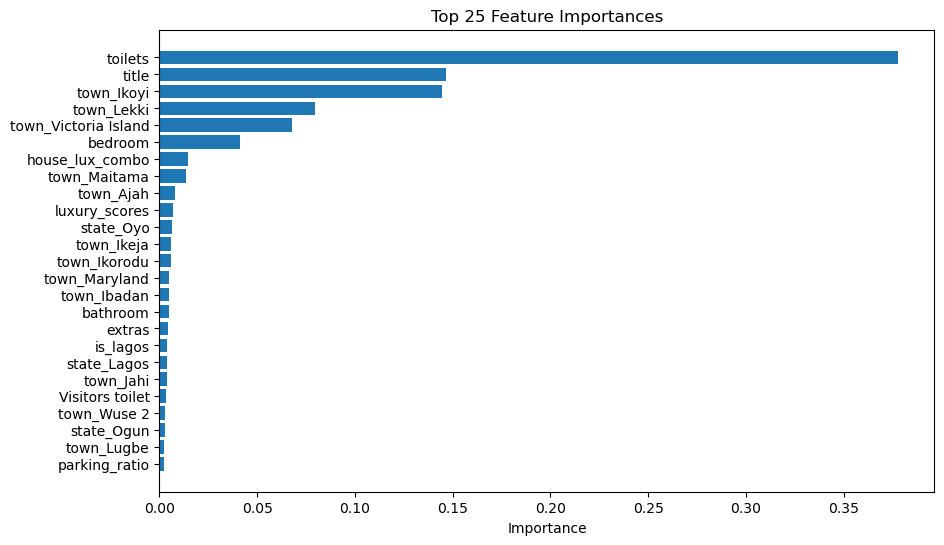

In [28]:
importances = model_5.feature_importance_dict

fi_df = pd.DataFrame(importances.items(), columns=["Feature", "Importance"])
fi_df = fi_df.sort_values(by="Importance", ascending=False)

#  Plotting Top 20 features
top_n = 25
plt.figure(figsize=(10, 6))
plt.barh(fi_df["Feature"].head(top_n), fi_df["Importance"].head(top_n))
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.show()

## 🔬Tunning Hyperparamter

In [29]:
n_estimators = [100,200, 400, 800, 1200]
max_depth = [None, 3, 5, 8, 15]
min_samples_split = np.arange(2,5,1)
min_samples_leaf = np.arange(1,6,1)
max_leaf_node = [None, 10, 20, 50, 100]
n_jobs = [-1]
cv=5

In [30]:
%%time
np.random.seed(42)
model_5.tune(n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_node,
    n_jobs=n_jobs,
    cv=cv)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=3, n_estimators=200, n_jobs=-1; total time=   1.5s
[CV] END max_depth=15, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=3, n_estimators=200, n_jobs=-1; total time=   1.7s
[CV] END max_depth=15

KeyboardInterrupt: 

In [ ]:
metrics_dict, y_preds = model_5.metrics()

In [ ]:
metrics_dict

{'mse': 118263150432765.53,
 'mae': 4261304.347340225,
 'mape': 0.39023962623981845,
 'r2': 0.5637464015502356}